In [170]:
import json, requests
import nltk
from selenium import webdriver
import re
from nltk.corpus import sentiwordnet as swn
import time
import timeit
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
import pandas as pd
import numpy as np
import urllib.request, urllib.parse, urllib.error
import csv
import pandas_datareader as web
import datetime

import seaborn as sns
import matplotlib.pyplot as plt


Get Reddit Data

In [171]:
def get_reddit_stats(url, num_its):
    time.sleep(2)
    text = []
    times = []
    up = []


    r = requests.get(url,  headers={'user-agent': 'Mozilla/5.0'})


    for post in r.json()['data']['children']:
        text.append(post['data']['title'])
        times.append(post['data']['created_utc'])
        up.append(post['data']['ups'])
        
    num = 0
    
    while num < num_its:
        urla = url + '&after=' + r.json()['data']['after']
        r = requests.get(urla, headers={'user-agent': 'Mozilla/5.0'})
        for post in r.json()['data']['children']:
            text.append(post['data']['title'])
            times.append(post['data']['created_utc'])
            up.append(post['data']['ups'])
        
        
        num += 1
    
        

    text = np.array(text)
    times = np.array(times)
    up = np.array(up)
    
    dfs = pd.DataFrame({'Sentence' : text, 'Time' : times, 'Up Votes' : up})

    return dfs


In [172]:
txt = get_reddit_stats('http://www.reddit.com/r/cryptocurrency/top.json?sort=top&t=year',35)

print('Done')

subreddits = ['bitcoin', 'btc', 'ethereum', 'ethtrader' ,'Crypto_Currency_News', 'DOGECOIN', 
              'RIPPLE', 'IOTA', 'cryptomarkets', 'altcoin']








for sub in subreddits:
    url = 'http://www.reddit.com/r/{}/top.json?sort=top&t=year'.format(sub)
    txt.append(get_reddit_stats(url,35))
    print(sub)

    





txt.drop_duplicates(subset = 'Sentence', inplace = True)

Done
bitcoin
btc
ethereum
ethtrader
Crypto_Currency_News
DOGECOIN
RIPPLE
IOTA
cryptomarkets
altcoin


In [173]:
txt.head()

,Sentence,Time,Up Votes
0,I still have not received my $27000 wire rever...,1.515438e+09,53748
1,+1(800)273-8255 - U.S. National Suicide Hotline,1.516126e+09,38718
2,CryptoNick is deleting all of his BitConnect v...,1.516190e+09,26393
3,"I will tell you exactly what is going on here,...",1.517851e+09,20005
4,Robinhood is launching a Crypto Trading app to...,1.516897e+09,19899


Sentiment Analysis

In [174]:
sid = SentimentIntensityAnalyzer()
sen = []
neg = []
neu = []
pos = []
com = []


In [175]:
for sentence in txt['Sentence']:
    sen.append(sentence)
    neg.append(list(sid.polarity_scores(sentence).values())[0])
    neu.append(list(sid.polarity_scores(sentence).values())[1])
    pos.append(list(sid.polarity_scores(sentence).values())[2])
    com.append(list(sid.polarity_scores(sentence).values())[3])
    


In [176]:
sen = np.array(sen)
neg = np.array(neg)
neu = np.array(neu)
pos = np.array(pos)
com = np.array(com)


In [177]:
df = pd.DataFrame({'Sentence' : sen, 'Crypto Negative' : neg, 'Crypto Neutral' : neu, 'Crypto Positive' : pos, 'Crypto Compound' : com})
df = df.set_index('Sentence')
txt = txt.set_index('Sentence')

In [178]:
txt = df.join(txt)

In [179]:
txt.reset_index()
txt['Date'] = pd.to_datetime(txt['Time'] , unit = 's').dt.date



In [180]:
txt = txt.set_index('Date')
txt = txt.sort_index()

In [181]:
txt.head()

,Crypto Compound,Crypto Negative,Crypto Neutral,Crypto Positive,Time,Up Votes
Date,,,,,,
2017-05-22,0.0000,0.000,1.000,0.0,1.495415e+09,728
2017-06-16,0.0000,0.000,1.000,0.0,1.497615e+09,1608
2017-06-19,0.0000,0.000,1.000,0.0,1.497867e+09,1997
2017-07-03,-0.3182,0.315,0.685,0.0,1.499101e+09,1172
2017-07-10,-0.2960,0.136,0.864,0.0,1.499657e+09,817


Retrieve ETH Data

In [182]:
urlb = 'https://min-api.cryptocompare.com/data/histoday?fsym=ETH&tsym=USD&limit=999&aggregate=3&e=CCCAGG'
uhb = urllib.request.urlopen(urlb)
datab = uhb.read().decode('utf8', 'ignore')
jsb = json.loads(datab)

tE = []
closeETH = []
volumefromE = []
volumetoE = []

# parse through json data


for w in jsb['Data']:
	closeETH.append(w['close'])
    
for z in jsb['Data']:
	tE.append(z['time'])

for e in jsb['Data']:
	volumefromE.append(e['volumefrom'])

for r in jsb['Data']:
	volumetoE.append(r['volumeto'])


dataETH = {'Time ETH' : pd.Series(tE), 'ETH Price': pd.Series(closeETH),'ETH Volume': pd.Series(volumefromE), 'ETH Volume in USD': pd.Series(volumetoE)}
dfETH = pd.DataFrame(dataETH)

In [183]:
dfETH.head()

,ETH Price,ETH Volume,ETH Volume in USD,Time ETH
0,0.0,0.0,0.0,1348876800
1,0.0,0.0,0.0,1349136000
2,0.0,0.0,0.0,1349395200
3,0.0,0.0,0.0,1349654400
4,0.0,0.0,0.0,1349913600


Retrieve BTC Data

In [184]:
# Retrieve BTC Data

urla = 'https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=999&aggregate=3&e=CCCAGG'
uha = urllib.request.urlopen(urla)
dataa = uha.read().decode('utf8', 'ignore')
jsa = json.loads(dataa)

t = []
closeBTC = []
volumefrom = []
volumeto = []

# parse through json data

for a in jsa['Data']:
	t.append(a['time'])

for b in jsa['Data']:
	closeBTC.append(b['close'])

for f in jsa['Data']:
	volumefrom.append(f['volumefrom'])

for g in jsa['Data']:
	volumeto.append(g['volumeto'])



dataBTC = {'Time BTC': pd.Series(t),'BTC Price': pd.Series(closeBTC),'BTC Volume': pd.Series(volumefrom), 'BTC Volume in USD': pd.Series(volumeto)}
dfBTC = pd.DataFrame(dataBTC)


In [185]:
dfETH = dfETH.rename(columns = {'Time ETH' : 'Date'})
dfBTC = dfBTC.rename(columns = {'Time BTC' : 'Date'})
dfETH['Date'] = pd.to_datetime(dfETH['Date'] , unit = 's')
dfBTC['Date'] = pd.to_datetime(dfBTC['Date'] , unit = 's')
dfETH = dfETH.set_index('Date')
dfBTC = dfBTC.set_index('Date')

In [186]:
cryptoprice = dfBTC.join(dfETH)
cryptoprice.head()

,BTC Price,BTC Volume,BTC Volume in USD,ETH Price,ETH Volume,ETH Volume in USD
Date,,,,,,
2012-09-29,12.40,49682.26,615588.21,0.0,0.0,0.0
2012-10-02,12.85,121733.57,1553834.75,0.0,0.0,0.0
2012-10-05,11.80,119443.88,1471753.08,0.0,0.0,0.0
2012-10-08,12.12,172429.27,1995375.72,0.0,0.0,0.0
2012-10-11,11.86,53231.35,639875.91,0.0,0.0,0.0


In [187]:
final = cryptoprice.join(txt, how = 'outer')

In [188]:
final.tail(3)

,BTC Price,BTC Volume,BTC Volume in USD,ETH Price,ETH Volume,ETH Volume in USD,Crypto Compound,Crypto Negative,Crypto Neutral,Crypto Positive,Time,Up Votes
Date,,,,,,,,,,,,
2018-03-19,NaN,NaN,NaN,NaN,NaN,NaN,0.2449,0.134,0.672,0.194,1.521462e+09,947.0
2018-03-19,NaN,NaN,NaN,NaN,NaN,NaN,0.5423,0.000,0.720,0.280,1.521481e+09,1273.0
2018-03-20,8992.75,190413.74,1.681041e+09,570.46,886518.9,4.917581e+08,NaN,NaN,NaN,NaN,NaN,NaN


In [189]:
final['BTC Price Change'] = final['BTC Price'].pct_change()*100
final['ETH Price Change'] = final['ETH Price'].pct_change()*100


Final Dataset

In [190]:
final.tail(15)

,BTC Price,BTC Volume,BTC Volume in USD,ETH Price,ETH Volume,ETH Volume in USD,Crypto Compound,Crypto Negative,Crypto Neutral,Crypto Positive,Time,Up Votes,BTC Price Change,ETH Price Change
Date,,,,,,,,,,,,,,
2018-03-16,NaN,NaN,NaN,NaN,NaN,NaN,-0.2411,0.141,0.859,0.000,1.521178e+09,4452.0,NaN,NaN
2018-03-17,8623.14,482267.18,3.885272e+09,555.55,2578048.7,1.347157e+09,-0.0258,0.321,0.370,0.309,1.521278e+09,4369.0,4.103592,-7.490050
2018-03-18,NaN,NaN,NaN,NaN,NaN,NaN,0.5827,0.000,0.818,0.182,1.521361e+09,1552.0,NaN,NaN
2018-03-18,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.000,1.000,0.000,1.521369e+09,772.0,NaN,NaN
2018-03-18,NaN,NaN,NaN,NaN,NaN,NaN,0.2057,0.000,0.878,0.122,1.521408e+09,5695.0,NaN,NaN
2018-03-18,NaN,NaN,NaN,NaN,NaN,NaN,0.3089,0.000,0.899,0.101,1.521350e+09,4658.0,NaN,NaN
2018-03-19,NaN,NaN,NaN,NaN,NaN,NaN,0.7506,0.000,0.764,0.236,1.521472e+09,966.0,NaN,NaN
2018-03-19,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.000,1.000,0.000,1.521443e+09,793.0,NaN,NaN
2018-03-19,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.000,1.000,0.000,1.521457e+09,1923.0,NaN,NaN


Visualization

In [217]:
dfBTCPriceC = final[['BTC Price Change', 'Crypto Compound', 'Crypto Negative', 'Crypto Neutral', 'Crypto Positive']]
dfETHPriceC = final[['ETH Price Change', 'Crypto Compound', 'Crypto Negative', 'Crypto Neutral', 'Crypto Positive']]
dfBTCPrice = final[['BTC Price', 'Crypto Compound', 'Crypto Negative', 'Crypto Neutral', 'Crypto Positive']]
dfETHPrice = final[['ETH Price', 'Crypto Compound', 'Crypto Negative', 'Crypto Neutral', 'Crypto Positive']]
dfBTCVol = final[['BTC Volume', 'Crypto Compound', 'Crypto Negative', 'Crypto Neutral', 'Crypto Positive']]
dfETHVol = final[['ETH Volume', 'Crypto Compound', 'Crypto Negative', 'Crypto Neutral', 'Crypto Positive']]

In [260]:
vis = final[['BTC Price', 'BTC Price Change', 'BTC Volume',
       'ETH Price', 'ETH Price Change', 'ETH Volume',
      'Crypto Compound','Crypto Positive', 'Crypto Negative', 'Crypto Neutral']]
viscorr = vis.corr()
viscov = vis.cov()

In [261]:
viscorr = viscorr.drop(columns = ['BTC Price', 'BTC Price Change', 'BTC Volume', 'ETH Price', 
                                  'ETH Price Change', 'ETH Volume'])

viscorr = viscorr.drop(viscorr.index[-4:])
viscorr


,Crypto Compound,Crypto Positive,Crypto Negative,Crypto Neutral
BTC Price,-0.089491,-0.097783,0.038737,0.056327
BTC Price Change,0.005917,0.035828,-0.049412,0.003117
BTC Volume,-0.063980,-0.072286,0.071322,0.012936
ETH Price,-0.057289,-0.099825,0.043809,0.054661
ETH Price Change,-0.074068,0.013118,0.023878,-0.027180
ETH Volume,-0.112201,-0.084470,0.041285,0.043369


In [262]:
viscov = viscov.drop(columns = ['BTC Price', 'BTC Price Change', 'BTC Volume', 'ETH Price', 
                                  'ETH Price Change', 'ETH Volume'])

viscov = viscov.drop(viscov.index[-4:])
viscov

,Crypto Compound,Crypto Positive,Crypto Negative,Crypto Neutral
BTC Price,-111.697617,-51.990472,16.433690,35.577542
BTC Price Change,0.011421,0.029457,-0.032414,0.003045
BTC Volume,-4828.833202,-2324.048516,1829.621708,494.084373
ETH Price,-5.874374,-4.360433,1.526848,2.836382
ETH Price Change,-0.154531,0.011659,0.016933,-0.028697
ETH Volume,-50875.666679,-16316.061476,6362.767788,9951.484764


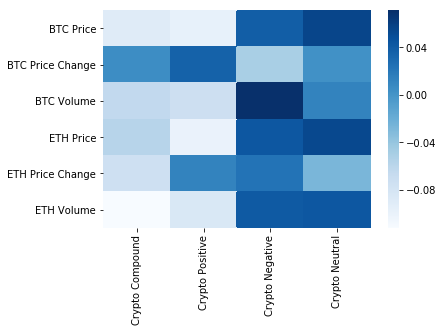

In [264]:
sns.heatmap(viscorr, 
 cmap = 'Blues')

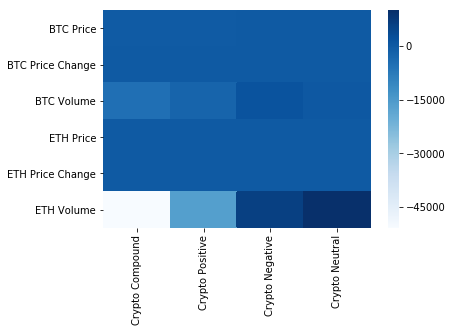

In [265]:
sns.heatmap(viscov, 
 cmap = 'Blues')

In [194]:
dfETHPriceC.corr()


,ETH Price Change,Crypto Compound,Crypto Negative,Crypto Neutral,Crypto Positive
ETH Price Change,1.000000,-0.074068,0.023878,-0.027180,0.013118
Crypto Compound,-0.074068,1.000000,-0.614120,-0.172797,0.683747
Crypto Negative,0.023878,-0.614120,1.000000,-0.536880,-0.155189
Crypto Neutral,-0.027180,-0.172797,-0.536880,1.000000,-0.750119
Crypto Positive,0.013118,0.683747,-0.155189,-0.750119,1.000000


In [195]:
dfBTCPrice.corr()

,BTC Price,Crypto Compound,Crypto Negative,Crypto Neutral,Crypto Positive
BTC Price,1.000000,-0.089491,0.038737,0.056327,-0.097783
Crypto Compound,-0.089491,1.000000,-0.614120,-0.172797,0.683747
Crypto Negative,0.038737,-0.614120,1.000000,-0.536880,-0.155189
Crypto Neutral,0.056327,-0.172797,-0.536880,1.000000,-0.750119
Crypto Positive,-0.097783,0.683747,-0.155189,-0.750119,1.000000


In [196]:
dfETHPrice.corr()

,ETH Price,Crypto Compound,Crypto Negative,Crypto Neutral,Crypto Positive
ETH Price,1.000000,-0.057289,0.043809,0.054661,-0.099825
Crypto Compound,-0.057289,1.000000,-0.614120,-0.172797,0.683747
Crypto Negative,0.043809,-0.614120,1.000000,-0.536880,-0.155189
Crypto Neutral,0.054661,-0.172797,-0.536880,1.000000,-0.750119
Crypto Positive,-0.099825,0.683747,-0.155189,-0.750119,1.000000


In [197]:
dfBTCVol.corr()

,BTC Volume,Crypto Compound,Crypto Negative,Crypto Neutral,Crypto Positive
BTC Volume,1.000000,-0.063980,0.071322,0.012936,-0.072286
Crypto Compound,-0.063980,1.000000,-0.614120,-0.172797,0.683747
Crypto Negative,0.071322,-0.614120,1.000000,-0.536880,-0.155189
Crypto Neutral,0.012936,-0.172797,-0.536880,1.000000,-0.750119
Crypto Positive,-0.072286,0.683747,-0.155189,-0.750119,1.000000


In [198]:
dfETHVol.corr()

,ETH Volume,Crypto Compound,Crypto Negative,Crypto Neutral,Crypto Positive
ETH Volume,1.000000,-0.112201,0.041285,0.043369,-0.084470
Crypto Compound,-0.112201,1.000000,-0.614120,-0.172797,0.683747
Crypto Negative,0.041285,-0.614120,1.000000,-0.536880,-0.155189
Crypto Neutral,0.043369,-0.172797,-0.536880,1.000000,-0.750119
Crypto Positive,-0.084470,0.683747,-0.155189,-0.750119,1.000000


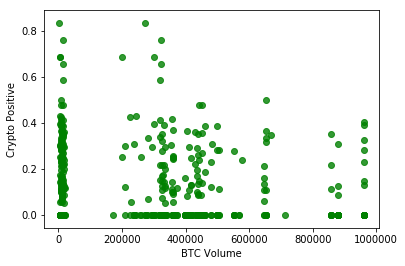

In [199]:
BTCprice = sns.regplot(x=final["BTC Price"], y=final['Crypto Positive'], fit_reg=False, color = 'g')
BTCvol = sns.regplot(x=final["BTC Volume"], y=final['Crypto Positive'], fit_reg=False, color = 'g')

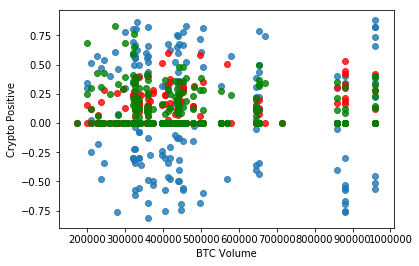

In [200]:
sns.regplot(x=final["BTC Volume"], y=final['Crypto Compound'], fit_reg=False)
sns.regplot(x=final["BTC Volume"], y=final['Crypto Negative'], fit_reg=False, color = 'r')
sns.regplot(x=final["BTC Volume"], y=final['Crypto Positive'], fit_reg=False, color = 'g')

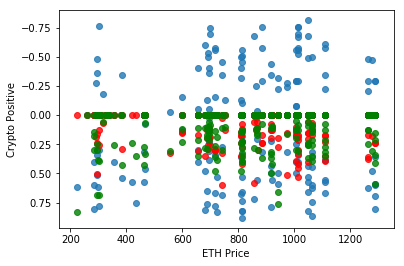

In [201]:
sns.regplot(x=final["ETH Price"], y=final['Crypto Compound'], fit_reg=False)
sns.regplot(x=final["ETH Price"], y=final['Crypto Negative'], fit_reg=False, color = 'r')
sns.regplot(x=final["ETH Price"], y=final['Crypto Positive'], fit_reg=False, color = 'g').invert_yaxis()

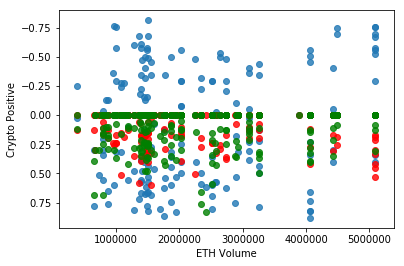

In [202]:
sns.regplot(x=final["ETH Volume"], y=final['Crypto Compound'], fit_reg=False)
sns.regplot(x=final["ETH Volume"], y=final['Crypto Negative'], fit_reg=False, color = 'r')
sns.regplot(x=final["ETH Volume"], y=final['Crypto Positive'], fit_reg=False, color = 'g').invert_yaxis()